In [12]:
from transformers import BertTokenizer, TFBertForMaskedLM
#from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
import numpy as np
import re
import matplotlib.pyplot as plt
from datasets import load_dataset
#from datasets import load_dataset, load_metric
#from sklearn.model_selection import train_test_split
#from transformers import Trainer, TrainingArguments
import streamlit as st

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

model.summary()

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "tf_bert_for_masked_lm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109514298 (417.76 MB)
Trainable params: 109514298 (417.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
# load in the dataset
dataset_name = "c4"
task_name = "en"
dataset = load_dataset(dataset_name, task_name, split="validation",streaming=True)

# count = 0
# for example in dataset:
#     if count >= 1000:
#         break
#     # Process or use the example as needed
#     print(example["text"])  # Or perform any other operation
#     count += 1

#convert dataset to a list so I can fine tune
dataset_list = list(dataset)

# sampleing subset for demonstration purposes
subset_size = 1000
data_subset = dataset_list[:min(subset_size, len(dataset_list))]

# extracting texts from the subset
texts = [example["text"] for example in data_subset]

# tokenize the texts
inputs = tokenizer(texts,max_length=100, padding='max_length', truncation=True, return_tensors="tf")

print(inputs.keys())


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [7]:
# Adding Labels
inp_ids = []
labels = []
max_label_length = 100
for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(100)) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
    num_of_token_to_mask = int(len(actual_tokens) * 0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    label = inp[token_to_mask].copy()
    inp[token_to_mask] = 103

    pad_length = max_label_length - len(label)
    label = np.pad(label, (0, pad_length), mode='constant', constant_values=0)

    inp_ids.append(inp)
    labels.append(label)
    
inp_ids = tf.convert_to_tensor(inp_ids)
labels = tf.convert_to_tensor(labels)
inputs['input_ids'] = inp_ids
inputs['labels'] = labels

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit([inputs.input_ids, inputs.attention_mask], inputs.labels, verbose=1, batch_size=8, epochs=3)

Epoch 1/3
125/125 [==============================] - 509s 4s/step - loss: 0.7988
Epoch 2/3
125/125 [==============================] - 453s 4s/step - loss: 0.6992
Epoch 3/3
125/125 [==============================] - 442s 4s/step - loss: 0.6010


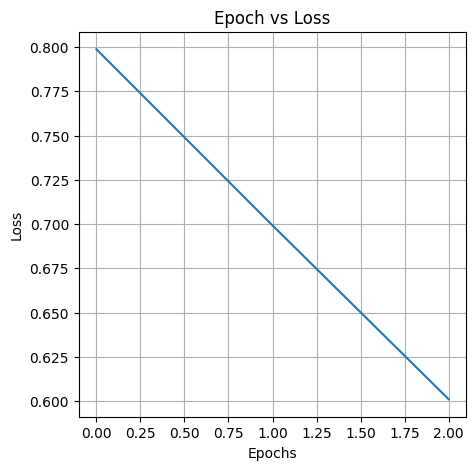

In [8]:
#plotting
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [11]:
query = "Good morning [MASK], have a [MASK] day"
inp = tokenizer(query,return_tensors='tf')
mask_loc = np.where(inp.input_ids.numpy()[0] == 103)[0].tolist()
out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()
tokenizer.decode(predicted_tokens)

'[PAD] [PAD]'

In [10]:
st.title("Sentence Creation")

st.subheader("Epoch Vs. Loss")
st.pyplot(fig)

st.write("Final Loss:", losses[-1])